# Data Questions
Using Python with Jupyter Notebook

by: __Khairil Azmi Ashari__ - Intek Data Scientist

***

In [25]:
from platform import python_version
print(python_version())

3.10.6


In [26]:
!pip list

Package                      Version
---------------------------- --------------
absl-py                      1.3.0
adagio                       0.2.4
amqp                         5.1.1
antlr4-python3-runtime       4.11.1
anyio                        3.6.1
appdirs                      1.4.4
APScheduler                  3.9.1
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asgiref                      3.5.2
asttokens                    2.0.5
astunparse                   1.6.3
async-timeout                4.0.2
attrs                        21.4.0
Babel                        2.10.3
backcall                     0.2.0
basemap                      1.3.4
basemap-data                 1.3.2
basemap-data-hires           1.3.2
beautifulsoup4               4.11.1
billiard                     3.6.4.0
bleach                       5.0.1
branca                       0.5.0
Brotli                       1.0.9
CacheControl                 0.12.11
cachetools                   5.2.0

Install Needed packages here, get rid of '#'

In [27]:
# install all needed packages if not already installed
# !pip install pandas
# !pip install duckdb
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install folium
# !pip install sqlalchemy
# !python.exe -m pip install --upgrade pip

# You Need to install this package to using geopandas
# !pip install pipwin
# !pipwin install gdal
# !pipwin install fiona
# !pip install geopandas

## Table of Contents<a class="anchor" id="toc"></a>
* [1. How many Response per day per user?](#chapter1)
    * [1.1 Survey Response per day per user](#section_1_1)
    * [1.2 Check Response per day per user](#section_1_2)
    * [1.3 Total Response per day per user](#section_1_3) 
* [2. Percentage of skipped Response from each data type?](#chapter2)
    * [2.1 Survey Response skipped percentage each data type](#section_2_1)
    * [2.2 Check Response skipped percentage each data type](#section_2_2)
    * [2.3 Total Response skipped percentage each data type](#section_2_3)
* [3. How much certain Prompt or Response been skipped?](#chapter3)
    * [3.1 Are certain Prompt skipped more?](#section_3_1)
    * [3.2 Are certain Response skipped more?](#section_3_2)
* [4. Percentage of Who Had Most Not Confirmed Response?](#chapter4)
    * [4.1 Survey Response Percentage of Who Had Most Not Confirmed](#section_4_1)
    * [4.2 Check Response Percentage of Who Had Most Not Confirmed](#section_4_2)
    * [4.3 Total Response Percentage of Who Had Most Not Confirmed](#section_4_3)
* [5. Where are Users Using The App From?](#chapter5)
    * [5.1 Based on Unique Location](#section_5_1)
        * [5.1.1 Survey Responses Unique Location](#sub_section_5_1_1)
        * [5.1.2 Check Responses Unique Location](#sub_section_5_1_2)
        * [5.1.3 Total Response Unique Location](#sub_section_5_1_3)
    * [5.2 Based on User Unique Location](#section_5_2)
        * [5.2.1 Survey Response User Unique Location](#sub_section_5_2_1)
        * [5.2.2 Check Response User Unique Location](#sub_section_5_2_2)
        * [5.2.3 Total Response User Unique Location](#sub_section_5_2_3)
    * [5.3 User Count Each Sub District (Kecamatan) Heat Map](#section_5_3)
        * [5.3.1 Survey Response User Count Each Sub District](#sub_section_5_3_1)
        * [5.3.2 Check Response User Count Each Sub District](#sub_section_5_3_2)
        * [5.3.3 Total Response User Count Each Sub District](#sub_section_5_3_3)
    * [5.4 Response Count Each Sub District (Kecamatan) Heat Map](#section_5_4)
        * [5.4.1 Survey Response Response Count Each Sub District](#sub_section_5_4_1)
        * [5.4.2 Survey Check Response Count Each Sub District](#sub_section_5_4_2)
        * [5.4.3 Total Response Response Count Each Sub District](#sub_section_5_4_3)
* [6. Daily Active User Count?](#chapter6)
    * [6.1 Survey Response Daily Active User](#section_6_1)
    * [6.2 Check Response Daily Active User](#section_6_2)
    * [6.3 Total Response Daily Active User](#section_6_3)
* [7. Daily Responses Count?](#chapter7)
    * [7.1 Survey Response Daily Responses Count](#section_7_1)
    * [7.2 Check Response Daily Responses Count](#section_7_2)
    * [7.3 Total Response Daily Responses Count](#section_7_3)
* [8. Are they filling the survey out at one time or throughout the day? What times? How long is it taking?](#chapter8)
    * [8.1 Survey Response Session Time Long](#section_8_1)
    * [8.2 Check Response Session Time Long](#section_8_2)
    * [8.3 Total Response Session Time Long](#section_8_3)
* [9. List of have not been confirmed Responses after check data](#chapter9)
* [10. List of confirmed Response](#chapter10)

Run Needed Function to do visualisation, etc

In [28]:
from datetime import datetime, timedelta
from folium.plugins import MarkerCluster
from matplotlib import pyplot as plt
from geopandas.tools import sjoin
import geopandas as gpd
import seaborn as sns
import folium, duckdb
import pandas as pd
import numpy as np

# Function needed to show graphic
def show_graph(df, x, y, x_rotate, title, xlabel, ylabel, fmt, sort):
    plt.figure(figsize=(15,5))
    if sort:
        df_sort = df.sort_values(by=sort, ascending=False)
        plot_order = df_sort[x].values
        ax = sns.barplot(data=df, x=x, y=y, order=plot_order)
    else:
        ax = sns.barplot(data=df, x=x, y=y)
    
    if isinstance(fmt, pd.Series) == True :
        ax.bar_label(ax.containers[0], labels=fmt)
    else:
        if fmt == False:
            ax.bar_label(ax.containers[0])
        else:
            ax.bar_label(ax.containers[0], fmt=fmt)

    # Rotate x ticks label if user_ids override each other 
    plt.xticks(rotation=x_rotate)
    plt.title(title, bbox={'facecolor':'0.8', 'pad':3})
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)
    plt.show()
    
# Function needed to show map
def show_map(q, loc_data, arg1, arg2):
    marker_cluster = MarkerCluster()
    
    open_map = folium.Map(tiles='openstreetmap')
    open_map.add_child(marker_cluster)

    for lat, long, x, y in q:
        coordinate = [lat,long]
        folium.map.Marker(
            coordinate,
            icon=None,
            popup=arg1+': '+str(x)+', '+arg2+': '+str(y)
        ).add_to(marker_cluster)

    south_west_corner = min(loc_data)
    north_east_corner = max(loc_data)
    open_map.fit_bounds([south_west_corner, north_east_corner])

    display(open_map)

# Function to load file to GeoDataFrame
def load_file_to_gdf(import_filename):
    data = gpd.read_file(import_filename) 
    
    return data

# Function to cleaned & preprocesses kecamatan broder
def preprocess_gdf(file):
    # Load kecamatan shape file to gdf
    gdf = load_file_to_gdf(file)
    # Drop NaN and None
    gdf = gdf.replace(to_replace='None', value=np.nan).dropna()
    # For use only Aceh and SUMUT
    # gdf = gdf.query('Provinsi.str.contains("ACEH") or Provinsi.str.contains("SUMATERA UTARA")' , engine='python')
    # Drop unnecessery column
    gdf = gdf.drop(['No','Objek','Kode_Kab','Kode_Kec'], axis=1)
    # Rearrange column
    gdf = gdf[['Kecamatan','Kab_Kota','Provinsi','geometry']]
    # Rename column
    gdf.rename(columns = {'Kecamatan':'sdistrict','Kab_Kota':'district','Provinsi':'province'}, inplace=True)
    
    return gdf

# Function to map point to its respective sub district (Kecamatan)
def mapping_point(data, sdistrict_gdf, arg1,arg2, arg3):
    gdf = gpd.GeoDataFrame(data, geometry = gpd.points_from_xy(data.longitude, data.latitude))
    gdf.drop(['latitude', 'longitude'], axis=1, inplace=True)
    gdf.crs = "EPSG:4326" #Convert GEoDataFrame to crs

    # Determine point on village
    point_in_district = sjoin(gdf, sdistrict_gdf, predicate='within', how='inner' )
    gdf_sorted = point_in_district.sort_values('index_right')

    gdf_sorted.drop(['geometry','index_right','district','province'], axis=1, inplace=True)
    sorted_df = pd.DataFrame(gdf_sorted)
    
    # group by sdistrict
    result = duckdb.query("SELECT "+arg1+"("+arg2+") AS '"+arg3+"', sdistrict FROM sorted_df GROUP BY sdistrict;").df()
    result = sdistrict_gdf.merge(result, on = 'sdistrict')
    
    return result

# Function to process and show heat map
def show_heatMap(data, legend_name,arg1):
    # create a numpy array of length 6 and has linear spacing from the minimum total user to the maximum total user
    threshold_scale = np.linspace(data[arg1].min(),
                                  data[arg1].max(),
                                  6, dtype=int)
    threshold_scale = threshold_scale.tolist() # change the numpy array to a list
    threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

    # create a plain aceh sumut map
    heat_map = folium.Map(tiles='cartodbpositron', name='light mode', location=[3.352913, 97.913223], zoom_start=9)
    folium.Choropleth(
        geo_data = data,
        data = data,
        columns = ['sdistrict', arg1],
        key_on='feature.properties.sdistrict',
        fill_color='YlGnBu', 
        fill_opacity=0.5, 
        line_opacity=0.2,
        legend_name=legend_name,
        nan_fill_color='white',
        nan_fill_opacity=0.5,
        highlight=True,
        reset=True,
        smooth_factor=0,
        overlay=True,
        show=True,
        name=arg1
    ).add_to(heat_map)

    # Add hover functionallity.
    style_function = lambda x: {'fillColor': '#ffffff', 'color':'#000000', 'fillOpacity': 0.1, 'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 'color':'#000000', 'fillOpacity': 0.50, 'weight': 0.1}
    NIL = folium.features.GeoJson(
        data = data,
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function, 
        tooltip=folium.features.GeoJsonTooltip(
            fields=['sdistrict','district','province',arg1],
            aliases=['Kecamatan :','Kabupaten :','Provinsi :', arg1+' :'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
    )
    heat_map.add_child(NIL)
    heat_map.keep_in_front(NIL)


    # Add street map mode
    folium.TileLayer('openstreetmap', name='street map', control=True).add_to(heat_map)

    folium.LayerControl(collapsed=True).add_to(heat_map)
    display(heat_map)

    
# Convert dataframe to CSV
def print_csv(data, filename):
    data.to_csv(filename+'.csv', sep=';', index=False)
    print('Data '+filename+' Printed to CSV')

# Process on counting interval time and session count

def process_session(df):
    # Creating interval column
    intervalList = []
    # Fill Session column with default value
    df['session'] = 1

    for index in range(len(df)):
        if((index < len(df)-1) and (df.at[index, 'user'] == df.at[index+1, 'user']) and (df.at[index, 'date'] == df.at[index+1, 'date'])):
            interval = df.at[index+1, 'datetime'] - df.at[index, 'datetime']
            intervalList.append(interval)
            if(interval > timedelta(minutes=10)):
                df.at[index+1, 'session'] = df.at[index, 'session'] + 1
            else:
                df.at[index+1, 'session'] = df.at[index, 'session']
        else:
            intervalList.append(timedelta(seconds=0))
    df['interval'] = intervalList
    
    df_final = pd.DataFrame({'min_datetime' : df.groupby(['user', 'date', 'session'])['datetime'].min(), 'max_datetime' : df.groupby(['user', 'date', 'session'])['datetime'].max()}).reset_index()
    df_final['session_time'] = df_final['max_datetime'] - df_final['min_datetime']
    df_final = df_final.sort_values(by='session_time', ascending=False).reset_index()

    return df_final

def timedelta_format(timedelta):
    ts = timedelta.total_seconds()
    hours, remainder = divmod(ts, 3600)
    minutes, seconds = divmod(remainder, 60)
    return ('{}:{:02d}:{:02d}').format(int(hours), int(minutes), int(seconds)) 

Function and Code to Load Necessery Data

In [29]:
from sqlalchemy.engine import URL
from sqlalchemy import text
import sqlalchemy as db

# Database database object
params = URL.create(
    'mysql+mysqldb',
    username = 'intek_admin',
    password = 'AVNS_DReg4Yip3xuEzfuYEbX',
    host = 'db-mysql-sgp1-90709-do-user-12808653-0.b.db.ondigitalocean.com',
    port = '25060',
    database = 'ikata_v2'
)

# Connect to ikata_v2 database
engine = db.create_engine(params)
conn = engine.connect()
metadata = db.MetaData()

# Function Needed to load all dataframe table database
def load_table(tablename):
    table = db.Table(tablename, metadata, autoload=True, autoload_with = engine)
    query = db.select([table])
    result = conn.execute(query).fetchall()
    df = pd.DataFrame(result)
    df.columns = result[0].keys()
    
    return table, df

# Function Needed to load dataframe from query
def load_query(query):
    query = text(query)
    result = conn.execute(query).fetchall()
    result_df = pd.DataFrame(result)
    
    return result_df

In [30]:
# Load history_survey data
history_survey, history_survey_df = load_table('history_survey')

history_survey_df.head()

,history_surveyid,date,responsed,skipped_survey,confirmed_survey,latitude,longitude,user,language,data_type
0,263,2022-08-13,10,5,10,0.000000,0.000000,171,1,1
1,264,2022-08-13,5,8,2,0.000000,0.000000,171,1,2
2,265,2022-08-14,1,1,1,0.000000,0.000000,171,1,1
3,266,2022-08-30,1,2,0,0.000000,0.000000,124,4,1
4,267,2022-08-30,24,0,21,0.000000,0.000000,201,1,1


In [31]:
# Load history_check data
history_check, history_check_df = load_table('history_check')

history_check_df.head()

,history_checkid,date,checked,skipped_check,confirmed_check,latitude,longitude,user,language,data_type
0,87,2022-08-16,1,0,1,0.000000,0.000000,169,1,1
1,88,2022-08-18,2,0,2,0.000000,0.000000,169,1,1
2,89,2022-08-30,1,1,1,0.000000,0.000000,124,1,1
3,90,2022-08-30,5,0,5,0.000000,0.000000,201,1,2
4,91,2022-08-30,5,0,5,0.000000,0.000000,202,1,2


In [32]:
# Combine history_survey and history_check data
history_survey_c = history_survey_df.copy()
history_check_c = history_check_df.copy()

history_survey_c[['date', 'response', 'skipped', 'confirmed', 'latitude', 'longitude', 'user', 'language', 'data_type']] = history_survey_c[['date', 'responsed', 'skipped_survey', 'confirmed_survey', 'latitude', 'longitude', 'user', 'language', 'data_type']]
history_check_c[['date', 'response', 'skipped', 'confirmed', 'latitude', 'longitude', 'user', 'language', 'data_type']] = history_check_c[['date', 'checked', 'skipped_check', 'confirmed_check', 'latitude', 'longitude', 'user', 'language', 'data_type']]

history_s = history_survey_c[['date', 'response', 'skipped', 'confirmed', 'latitude', 'longitude', 'user', 'language', 'data_type']]
history_c = history_check_c[['date', 'response', 'skipped', 'confirmed', 'latitude', 'longitude', 'user', 'language', 'data_type']]

history = pd.concat([history_s, history_c], ignore_index = True, sort = False)

history.head()

,date,response,skipped,confirmed,latitude,longitude,user,language,data_type
0,2022-08-13,10,5,10,0.000000,0.000000,171,1,1
1,2022-08-13,5,8,2,0.000000,0.000000,171,1,2
2,2022-08-14,1,1,1,0.000000,0.000000,171,1,1
3,2022-08-30,1,2,0,0.000000,0.000000,124,4,1
4,2022-08-30,24,0,21,0.000000,0.000000,201,1,1


In [33]:
# Load response data
response, response_df = load_table('response')

response_df.head()

,response_id,response,datetime,user,language,data_type,prompt,check_status,check_type
0,638,Raden Subantaka anak dakhi khaje Matasari,2022-08-13 05:55:41,171,1,2,70527,1,1
1,640,ngkabhang,2022-08-13 05:56:33,171,1,1,494,1,1
2,641,nangkih,2022-08-13 05:56:47,171,1,1,492,1,1
3,649,meputekh,2022-08-13 07:54:04,171,1,1,493,1,1
4,654,bhatu kakhang,2022-08-13 07:55:26,171,1,1,502,1,1


In [34]:
# Load check_response data
check_response, check_response_df = load_table('check_response')

check_response_df.head()

,check_responseid,check_response,datetime,user,response,check_status,check_type
0,826,terbang,2022-08-16 14:57:30,169,640,1,1
1,893,naik,2022-08-18 15:57:08,169,641,1,1
2,894,pasir,2022-08-18 15:57:34,169,656,1,1
3,1275,"ada istri nya empat, asal nya dari beberapa ne...",2022-08-30 03:19:03,204,725,1,1
4,1280,kabang,2022-08-30 03:20:03,205,640,1,1


In [35]:
# Combine response and check_response data
response_c = response_df.copy()
check_response_c = check_response_df.copy()

response_combine = pd.concat([response_c, check_response_c], ignore_index = True, sort = False)

response_combine.head()

,response_id,response,datetime,user,language,data_type,prompt,check_status,check_type,check_responseid,check_response
0,638.0,Raden Subantaka anak dakhi khaje Matasari,2022-08-13 05:55:41,171,1.0,2.0,70527.0,1,1,NaN,NaN
1,640.0,ngkabhang,2022-08-13 05:56:33,171,1.0,1.0,494.0,1,1,NaN,NaN
2,641.0,nangkih,2022-08-13 05:56:47,171,1.0,1.0,492.0,1,1,NaN,NaN
3,649.0,meputekh,2022-08-13 07:54:04,171,1.0,1.0,493.0,1,1,NaN,NaN
4,654.0,bhatu kakhang,2022-08-13 07:55:26,171,1.0,1.0,502.0,1,1,NaN,NaN


In [36]:
# Load prompt_sentence data
prompt_sentence, prompt_sentence_df = load_table('prompt_sentence')

prompt_sentence_df.head()

,prompt_id,data_type,prompt,priority
0,20518,3,Mengapa kebahagiaan datang dengan mudah bagi s...,20221117
1,20519,3,Kebijakan apa yang bisa diterapkan pemerintah ...,20221117
2,20520,3,Apa mimpi paling menakutkan yang pernah Anda a...,20221117
3,20521,3,Bagaimana negara Anda akan berubah jika anak-a...,20221117
4,20522,3,Jika Anda bisa mendesain acara televisi sepert...,20221117


In [37]:
# Load prompt_sentence data
prompt_word, prompt_word_df = load_table('prompt_word')

prompt_word_df.head()

,prompt_id,data_type,prompt,hint,priority,pos_tag,semantic_domain,external_id
0,1,1,segala sesuatu yang dapat kita lihat,alam semesta,20221024,8,1,
1,2,1,segala sesuatu yang dapat kita lihat,ciptaan,20221024,8,1,
2,3,1,Kata yang digunakan untuk menyebut segala sesu...,langit dan bumi,20221024,8,1,
3,4,1,Kata yang digunakan untuk menyebut segala sesu...,segala sesuatu yang ada,20221024,3,1,
4,5,1,Kata yang digunakan untuk menyebut langit.,langit,20221024,8,1.1,


In [38]:
# Combine prompt_word and prompt_sentence data
prompt_word_c = prompt_word_df.copy()
prompt_sentence_c = prompt_sentence_df.copy()

prompt_combine = pd.concat([prompt_word_c, prompt_sentence_c], ignore_index = True, sort = False)

prompt_combine.head()

,prompt_id,data_type,prompt,hint,priority,pos_tag,semantic_domain,external_id
0,1,1,segala sesuatu yang dapat kita lihat,alam semesta,20221024,8.0,1,
1,2,1,segala sesuatu yang dapat kita lihat,ciptaan,20221024,8.0,1,
2,3,1,Kata yang digunakan untuk menyebut segala sesu...,langit dan bumi,20221024,8.0,1,
3,4,1,Kata yang digunakan untuk menyebut segala sesu...,segala sesuatu yang ada,20221024,3.0,1,
4,5,1,Kata yang digunakan untuk menyebut langit.,langit,20221024,8.0,1.1,


In [39]:
# Load check_type data
check_type, check_type_df = load_table('check_type')

check_type_df.head()

,check_typeid,check_type
0,0,NOT YET CHECKED
1,1,DAILY CHECK
2,2,CHECK DATA
3,3,MANUAL CHECK


***
# 1. How many Response per day per user?<a class="anchor" id="chapter1"></a>

## 1.1 Survey Response per day per user<a class="anchor" id="section_1_1"></a>

In [40]:
q1_1 = load_query("SELECT user, SUM(responsed) AS 'total_survey_response', COUNT(DISTINCT(date)) AS 'day_of_use', ROUND(SUM(responsed)/COUNT(DISTINCT(date)), 2) AS 'average_survey_response_per_day' FROM history_survey GROUP BY(user) ORDER BY(average_survey_response_per_day) DESC;")

q1_1.head()

,user,total_survey_response,day_of_use,average_survey_response_per_day
0,0,461,5,92.20
1,214,1060,25,42.40
2,204,31,1,31.00
3,238,30,1,30.00
4,211,30,1,30.00


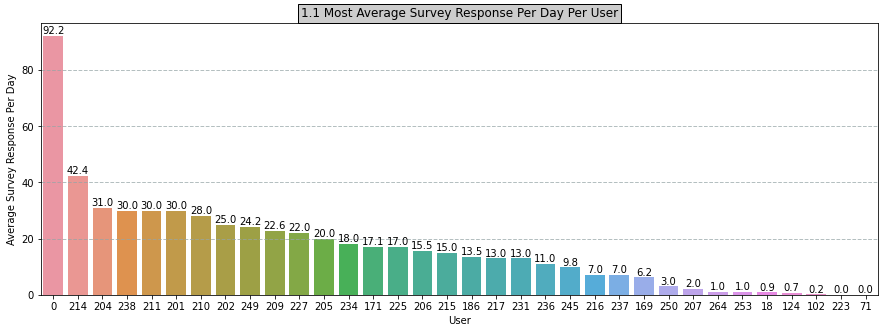

In [41]:
x = 'user'
y = 'average_survey_response_per_day'
title = '1.1 Most Average Survey Response Per Day Per User'
xlabel = 'User'
ylabel = 'Average Survey Response Per Day'
fmt='%.1f'

show_graph(q1_1, x, y, 0, title, xlabel, ylabel, fmt, y)

[Back to Table of Contents](#toc)

## 1.2 Check Response per day per user<a class="anchor" id="section_1_2"></a>

In [42]:
q1_2 = load_query("SELECT user, SUM(checked) AS 'total_check_response', COUNT(DISTINCT(date)) AS 'day_of_use', ROUND(SUM(checked)/COUNT(DISTINCT(date)), 2) AS 'average_check_response_per_day' FROM history_check GROUP BY(user) ORDER BY (average_check_response_per_day) DESC;")

q1_2.head()

,user,total_check_response,day_of_use,average_check_response_per_day
0,249,348,9,38.67
1,171,181,6,30.17
2,214,306,14,21.86
3,202,42,2,21.00
4,209,123,9,13.67


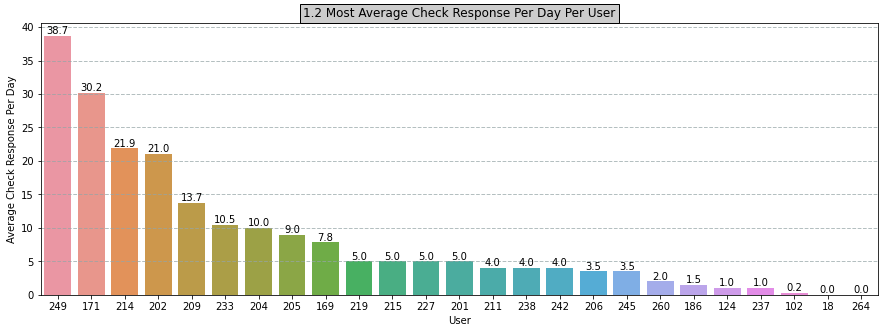

In [43]:
x = 'user'
y = 'average_check_response_per_day'
title = '1.2 Most Average Check Response Per Day Per User'
xlabel = 'User'
ylabel = 'Average Check Response Per Day'
fmt='%.1f'

show_graph(q1_2, x, y, 0, title, xlabel, ylabel, fmt, y)

[Back to Table of Contents](#toc)

## 1.3 Total Response per day per user<a class="anchor" id="section_1_3"></a>

In [44]:
q1_3 = pd.DataFrame({'total_response' : history.groupby(['user'])['response'].sum(), 'day_of_use' : history.groupby(['user'])['date'].nunique()}).reset_index()
q1_3['average_response_per_day'] = round(q1_3['total_response']/q1_3['day_of_use'], 2)

q1_3.head()

,user,total_response,day_of_use,average_response_per_day
0,0,461,5,92.20
1,18,15,18,0.83
2,71,0,2,0.00
3,102,2,6,0.33
4,124,4,3,1.33


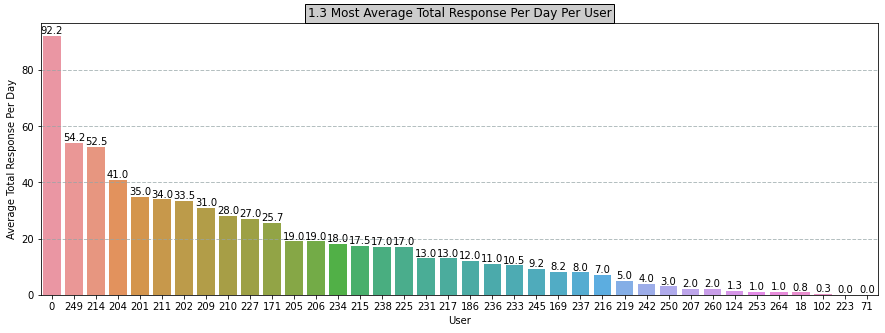

In [45]:
x = 'user'
y = 'average_response_per_day'
title = '1.3 Most Average Total Response Per Day Per User'
xlabel = 'User'
ylabel = 'Average Total Response Per Day'
fmt='%.1f'

show_graph(q1_3, x, y, 0, title, xlabel, ylabel, fmt, y)

[Back to Table of Contents](#toc)

***
# 2. Percentage of skipped Response from each data type?<a class="anchor" id="chapter2"></a>

## 2.1 Survey Response skipped percentage each data type<a class="anchor" id="section_2_1"></a>

In [46]:
q2_1 = load_query("SELECT data_type, SUM(skipped_survey) AS 'total_survey_skipped', SUM(responsed) AS 'total_responsed', SUM(skipped_survey)+SUM(responsed) AS 'total', ROUND(SUM(skipped_survey)/(SUM(skipped_survey)+SUM(responsed))*100, 2) AS 'percentage' FROM history_survey GROUP BY(data_type) ORDER BY (percentage) DESC;")

q2_1.head()

,data_type,total_survey_skipped,total_responsed,total,percentage
0,2,21,5,26,80.77
1,3,87,910,997,8.73
2,1,149,1800,1949,7.64


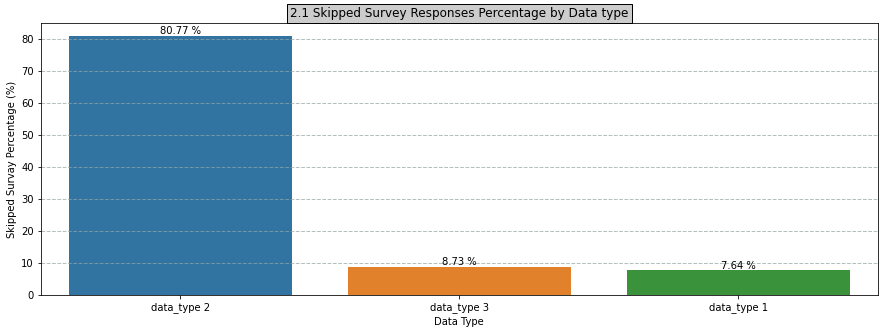

In [47]:
x = 'data_type ' + q2_1['data_type'].map(str)
y = 'percentage'
title = '2.1 Skipped Survey Responses Percentage by Data type'
xlabel = 'Data Type'
ylabel = 'Skipped Survay Percentage (%)'
fmt='%g %%'

show_graph(q2_1, x, y, 0, title, xlabel, ylabel, fmt, False)

[Back to Table of Contents](#toc)

## 2.2 Check Response skipped percentage each data type<a class="anchor" id="section_2_2"></a>

In [48]:
q2_2 = load_query("SELECT data_type, SUM(skipped_check) AS 'total_check_skipped', SUM(checked) AS 'total_checked', SUM(skipped_check)+SUM(checked) AS 'total', ROUND(SUM(skipped_check)/(SUM(skipped_check)+SUM(checked))*100, 2) AS 'percentage' FROM history_check GROUP BY(data_type) ORDER BY (percentage) DESC;")

q2_2.head()

,data_type,total_check_skipped,total_checked,total,percentage
0,3,5,13,18,27.78
1,2,8,69,77,10.39
2,1,85,1155,1240,6.85


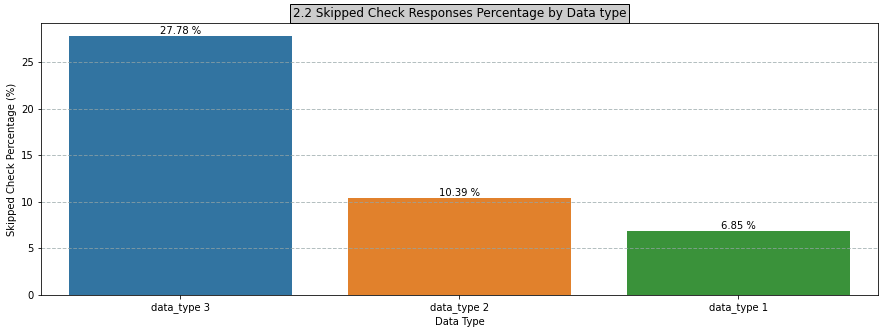

In [49]:
x = 'data_type ' + q2_2['data_type'].map(str)
y = 'percentage'
title = '2.2 Skipped Check Responses Percentage by Data type'
xlabel = 'Data Type'
ylabel = 'Skipped Check Percentage (%)'
fmt='%g %%'

show_graph(q2_2, x, y, 0, title, xlabel, ylabel, fmt, False)

[Back to Table of Contents](#toc)

## 2.3 Total Response skipped percentage each data type<a class="anchor" id="section_2_3"></a>

In [50]:
q2_3 = pd.DataFrame({'total_skipped' : history.groupby(['data_type'])['skipped'].sum(), 'total_response' : history.groupby(['data_type'])['response'].sum()}).reset_index()
q2_3['total'] = q2_3['total_skipped']+q2_3['total_response']
q2_3['percentage'] = round(q2_3['total_skipped']/q2_3['total']*100, 2)
q2_3 = q2_3.sort_values(by='percentage', ascending=False).reset_index()

q2_3.head()

,index,data_type,total_skipped,total_response,total,percentage
0,1,2,29,74,103,28.16
1,2,3,92,923,1015,9.06
2,0,1,234,2955,3189,7.34


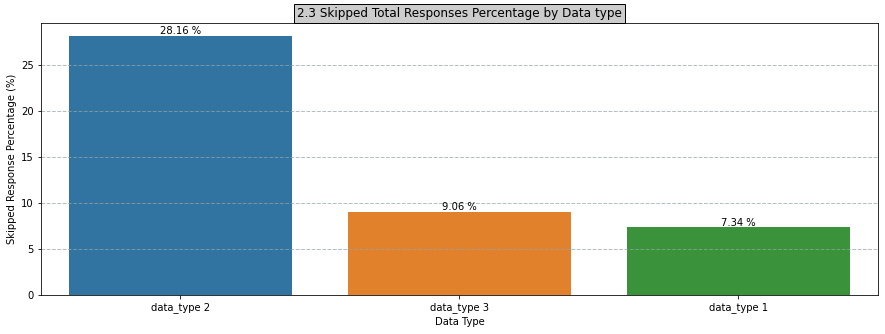

In [51]:
x = 'data_type ' + q2_3['data_type'].map(str)
y = 'percentage'
title = '2.3 Skipped Total Responses Percentage by Data type'
xlabel = 'Data Type'
ylabel = 'Skipped Response Percentage (%)'
fmt='%g %%'

show_graph(q2_3, x, y, 0, title, xlabel, ylabel, fmt, False)

[Back to Table of Contents](#toc)

***
# 3. How much certain Prompt or Response been skipped?<a class="anchor" id="chapter3"></a>

## 3.1 Are certain Prompt skipped more?<a class="anchor" id="section_3_1"></a>

In [52]:
q3_1 = load_query("SELECT data_type, prompt, skipped_count FROM skipped_prompt ORDER BY (skipped_count) DESC LIMIT 20;")

q3_1.head()

,data_type,prompt,skipped_count
0,1,1527,2
1,1,1534,2
2,3,285926,2
3,3,20522,2
4,1,1549,2


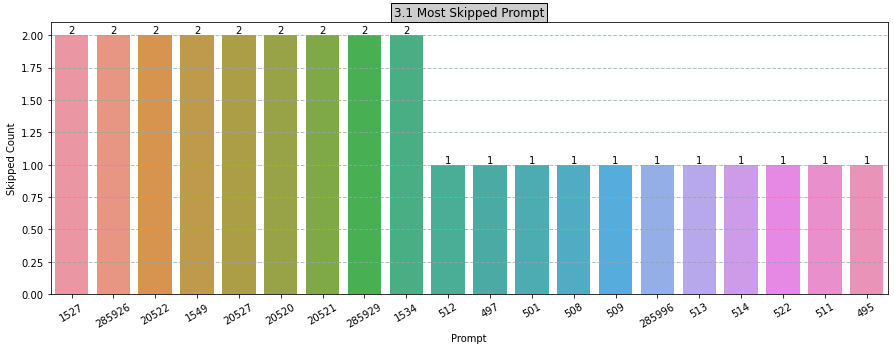

In [53]:
x = 'prompt'
y = 'skipped_count'
title = '3.1 Most Skipped Prompt'
xlabel = 'Prompt'
ylabel = 'Skipped Count'

show_graph(q3_1, x, y, 30, title, xlabel, ylabel, False, y)

[Back to Table of Contents](#toc)

## 3.2 Are certain Response skipped more?<a class="anchor" id="section_3_2"></a>

In [54]:
q3_2 = load_query("SELECT response, skipped_count FROM skipped_response ORDER BY (skipped_count) DESC LIMIT 20;")

q3_2.head()

,response,skipped_count
0,2376,2
1,3211,2
2,664,2
3,726,2
4,1269,2


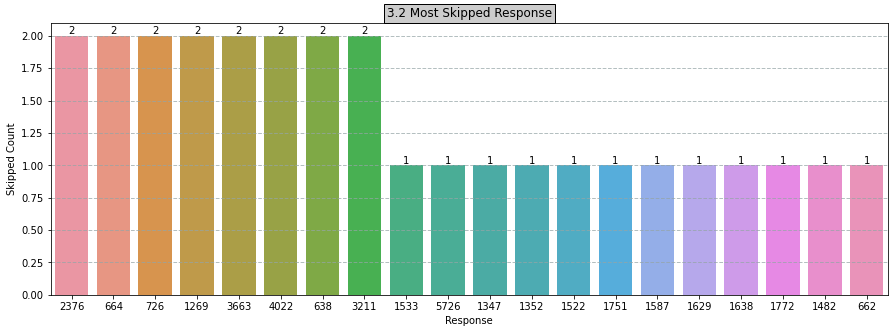

In [55]:
x = 'response'
y = 'skipped_count'
title = '3.2 Most Skipped Response'
xlabel = 'Response'
ylabel = 'Skipped Count'

show_graph(q3_2, x, y, 0, title, xlabel, ylabel, False, y)

[Back to Table of Contents](#toc)

***
# 4. Percentage of Who Had Most Not Confirmed Response?<a class="anchor" id="chapter4"></a>

## 4.1 Survey Response Percentage of Who Had Most Not Confirmed<a class="anchor" id="section_4_1"></a>

In [56]:
q4_1 = load_query("SELECT user, SUM(responsed) AS 'total_survey_response', SUM(confirmed_survey) AS 'total_confirmed_survey', SUM(responsed)-SUM(confirmed_survey) AS 'total_not_confirmed_survey', ROUND((SUM(responsed)-SUM(confirmed_survey))/SUM(responsed)*100, 2) AS 'not_confirmed_survey_percentage' FROM history_survey GROUP BY(user) ORDER BY(not_confirmed_survey_percentage) DESC;")
q4_1 = q4_1.fillna(value = 0)
q4_1.head()

,user,total_survey_response,total_confirmed_survey,total_not_confirmed_survey,not_confirmed_survey_percentage
0,124,2,0,2,100.00
1,18,15,8,7,46.67
2,214,1060,770,290,27.36
3,238,30,22,8,26.67
4,225,17,13,4,23.53


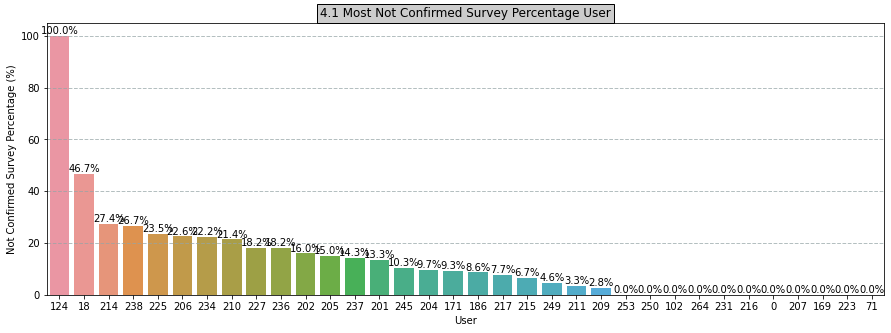

In [57]:
x = 'user'
y = 'not_confirmed_survey_percentage'
title = '4.1 Most Not Confirmed Survey Percentage User'
xlabel = 'User'
ylabel = 'Not Confirmed Survey Percentage (%)'
fmt = '%.1f%%'

show_graph(q4_1, x, y, 0, title, xlabel, ylabel, fmt, y)

[Back to Table of Contents](#toc)

## 4.2 Check Response Percentage of Who Had Most Not Confirmed<a class="anchor" id="section_4_2"></a>

In [58]:
q4_2 = load_query("SELECT user, SUM(checked) AS 'total_check_response', SUM(confirmed_check) AS 'total_confirmed_check', SUM(checked)-SUM(confirmed_check) AS 'total_not_confirmed_check', ROUND((SUM(checked)-SUM(confirmed_check))/SUM(checked)*100, 2) AS 'not_confirmed_check_percentage' FROM history_check GROUP BY(user) ORDER BY(not_confirmed_check_percentage) DESC;")
q4_2 = q4_2.fillna(value = 0)
q4_2.head()

,user,total_check_response,total_confirmed_check,total_not_confirmed_check,not_confirmed_check_percentage
0,102,1,0,1,100.00
1,124,2,1,1,50.00
2,260,2,1,1,50.00
3,233,21,13,8,38.10
4,186,3,2,1,33.33


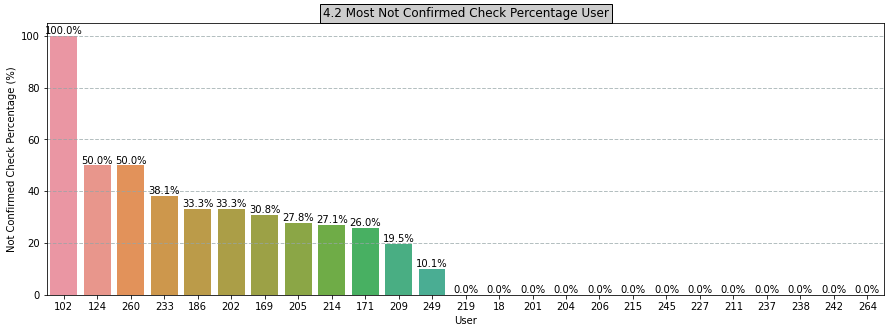

In [59]:
x = 'user'
y = 'not_confirmed_check_percentage'
title = '4.2 Most Not Confirmed Check Percentage User'
xlabel = 'User'
ylabel = 'Not Confirmed Check Percentage (%)'
fmt = '%.1f%%'

show_graph(q4_2, x, y, 0, title, xlabel, ylabel, fmt, y)

[Back to Table of Contents](#toc)

## 4.3 Total Response Percentage of Who Had Most Not Confirmed<a class="anchor" id="section_4_3"></a>

In [60]:
q4_3 = pd.DataFrame({'total_response' : history.groupby(['user'])['response'].sum(), 'total_confirmed' : history.groupby(['user'])['confirmed'].sum()}).reset_index()
q4_3['total_not_confirmed'] = q4_3['total_response'] - q4_3['total_confirmed']
q4_3['not_confirmed_percentage'] = round(q4_3['total_not_confirmed']/q4_3['total_response']*100, 2)
q4_3 = q4_3.sort_values(by='not_confirmed_percentage', ascending=False).reset_index()

q4_3.head()

,index,user,total_response,total_confirmed,total_not_confirmed,not_confirmed_percentage
0,4,124,4,1,3,75.00
1,3,102,2,1,1,50.00
2,36,260,2,1,1,50.00
3,1,18,15,8,7,46.67
4,26,233,21,13,8,38.10


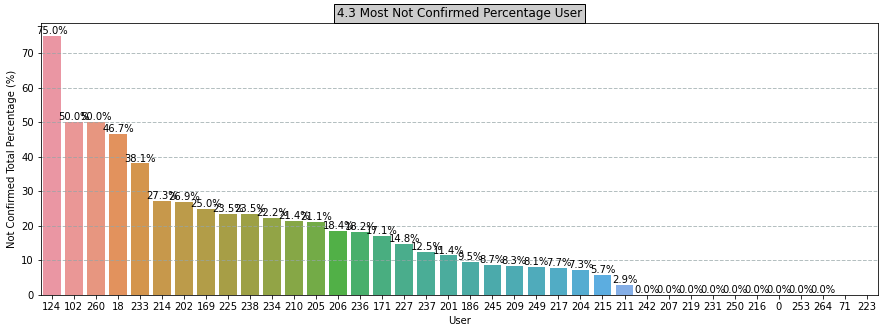

In [61]:
x = 'user'
y = 'not_confirmed_percentage'
title = '4.3 Most Not Confirmed Percentage User'
xlabel = 'User'
ylabel = 'Not Confirmed Total Percentage (%)'
fmt = '%.1f%%'

show_graph(q4_3, x, y, 0, title, xlabel, ylabel, fmt, y)

[Back to Table of Contents](#toc)

***
# 5. Where are Users Using The App From?<a class="anchor" id="chapter5"></a>

## 5.1 Based on Unique Location<a class="anchor" id="section_5_1"></a>

### 5.1.1 Survey Responses Unique Location<a class="anchor" id="sub_section_5_1_1"></a>

In [62]:
q5_1_1 = load_query("SELECT latitude, longitude, COUNT(DISTINCT(user)) AS 'total_user', SUM(responsed) AS 'total_survey_response' FROM history_survey WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY latitude, longitude;")
q5_1_1[['latitude', 'longitude']] = q5_1_1[['latitude', 'longitude']].astype('float64')
q5_1_1.head()

,latitude,longitude,total_user,total_survey_response
0,3.459459,97.817889,10,241
1,3.459459,97.835940,7,537
2,3.477477,97.819753,10,57
3,3.495495,97.803576,18,239
4,3.513514,97.819753,3,0


In [63]:
q5_1_1_zip = zip(q5_1_1.latitude, q5_1_1.longitude, q5_1_1.total_user, q5_1_1.total_survey_response)
loc_data = q5_1_1[['latitude','longitude']].values.tolist()
arg1 = 'total_user'
arg2 = 'total_survey_response'

show_map(q5_1_1_zip, loc_data, arg1, arg2)

[Back to Table of Contents](#toc)

### 5.1.2 Check Responses Unique Location<a class="anchor" id="sub_section_5_1_2"></a>

In [64]:
q5_1_2 = load_query("SELECT latitude, longitude, COUNT(DISTINCT(user)) AS 'total_user', SUM(checked) AS 'total_check_response' FROM history_check WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY latitude, longitude;")
q5_1_2[['latitude', 'longitude']] = q5_1_2[['latitude', 'longitude']].astype('float64')
q5_1_2.head()

,latitude,longitude,total_user,total_check_response
0,3.459459,97.817889,4,19
1,3.459459,97.835940,1,4
2,3.477477,97.819753,2,113
3,3.495495,97.803576,11,604


In [65]:
q5_1_2_zip = zip(q5_1_2.latitude, q5_1_2.longitude, q5_1_2.total_user, q5_1_2.total_check_response)
loc_data = q5_1_2[['latitude','longitude']].values.tolist()
arg1 = 'total_user'
arg2 = 'total_check_response'

show_map(q5_1_2_zip, loc_data, arg1, arg2)

[Back to Table of Contents](#toc)

### 5.1.3 Total Response Unique Location<a class="anchor" id="sub_section_5_1_3"></a>

In [66]:
q5_1_3 = pd.DataFrame({'total_user' : history.groupby(['latitude', 'longitude'])['user'].nunique(), 'total_response' : history.groupby(['latitude', 'longitude'])['response'].sum()}).reset_index()
q5_1_3 = q5_1_3.drop(q5_1_3[(q5_1_3['latitude'] == 0.0) & (q5_1_3['longitude'] == 0.0)].index)
q5_1_3[['latitude', 'longitude']] = q5_1_3[['latitude', 'longitude']].astype('float64')
q5_1_3.head()

,latitude,longitude,total_user,total_response
1,3.459459,97.817889,10,260
2,3.459459,97.835940,7,541
3,3.477477,97.819753,11,170
4,3.495495,97.803576,23,843
5,3.513514,97.819753,3,0


In [67]:
q5_1_3_zip = zip(q5_1_3.latitude, q5_1_3.longitude, q5_1_3.total_user, q5_1_3.total_response)
loc_data = q5_1_3[['latitude','longitude']].values.tolist()
arg1 = 'total_user'
arg2 = 'total_response'

show_map(q5_1_3_zip, loc_data, arg1, arg2)

[Back to Table of Contents](#toc)

***
## 5.2 Based on User Unique Location<a class="anchor" id="section_5_2"></a>

### 5.2.1 Survey Response User Unique Location<a class="anchor" id="sub_section_5_2_1"></a>

In [68]:
q5_2_1 = load_query("SELECT user, latitude, longitude, SUM(responsed) AS 'total_survey_response' FROM history_survey WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY user, latitude, longitude;")
q5_2_1[['latitude', 'longitude']] = q5_2_1[['latitude', 'longitude']].astype('float64')
q5_2_1.head()

,user,latitude,longitude,total_survey_response
0,201,3.495495,97.803576,6
1,202,3.495495,97.803576,20
2,216,3.495495,97.803576,4
3,217,3.495495,97.803576,13
4,225,3.495495,97.803576,17


In [69]:
q5_2_1_zip = zip(q5_2_1.latitude, q5_2_1.longitude, q5_2_1.user, q5_2_1.total_survey_response)
loc_data = q5_2_1[['latitude','longitude']].values.tolist()
arg1 = 'user'
arg2 = 'total_survey_response'

show_map(q5_2_1_zip, loc_data, arg1, arg2)

[Back to Table of Contents](#toc)

### 5.2.2 Check Response User Unique Location<a class="anchor" id="sub_section_5_2_2"></a>

In [70]:
q5_2_2 = load_query("SELECT user, latitude, longitude, SUM(checked) AS 'total_check_response' FROM history_check WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY user, latitude, longitude;")
q5_2_2[['latitude', 'longitude']] = q5_2_2[['latitude', 'longitude']].astype('float64')
q5_2_2.head()

,user,latitude,longitude,total_check_response
0,204,3.495495,97.803576,10
1,169,3.495495,97.803576,26
2,209,3.495495,97.803576,78
3,214,3.495495,97.803576,167
4,249,3.495495,97.803576,236


In [71]:
q5_2_2_zip = zip(q5_2_2.latitude, q5_2_2.longitude, q5_2_2.user, q5_2_2.total_check_response)
loc_data = q5_2_2[['latitude','longitude']].values.tolist()
arg1 = 'user'
arg2 = 'total_check_response'

show_map(q5_2_2_zip, loc_data, arg1, arg2)

[Back to Table of Contents](#toc)

### 5.2.3 Total Response User Unique Location<a class="anchor" id="sub_section_5_2_3"></a>

In [72]:
q5_2_3 = pd.DataFrame({'total_response' : history.groupby(['user', 'latitude', 'longitude'])['response'].sum()}).reset_index()
q5_2_3 = q5_2_3.drop(q5_2_3[(q5_2_3['latitude'] == 0.0) & (q5_2_3['longitude'] == 0.0)].index)
q5_2_3 = q5_2_3[q5_2_3['latitude'].notna()]
q5_2_3[['latitude', 'longitude']] = q5_2_3[['latitude', 'longitude']].astype('float64')
q5_2_3.head()

,user,latitude,longitude,total_response
0,0,3.459459,97.835940,461
1,0,3.477477,97.819753,0
3,18,3.459459,97.817889,5
4,18,3.459459,97.835940,0
5,18,3.477477,97.819753,3


In [73]:
q5_2_3_zip = zip(q5_2_3.latitude, q5_2_3.longitude, q5_2_3.user, q5_2_3.total_response)
loc_data = q5_2_3[['latitude','longitude']].values.tolist()
arg1 = 'user'
arg2 = 'total_response'

show_map(q5_2_3_zip, loc_data, arg1, arg2)

[Back to Table of Contents](#toc)

***
## 5.3 User Count Each Sub District (Kecamatan) Heat Map<a class="anchor" id="section_5_3"></a>

### 5.3.1 Survey Response User Count Each Sub District<a class="anchor" id="sub_section_5_3_1"></a>

In [74]:
# Get Geometry Border of Kecamatan (Sub District)
indonesia_gdf = preprocess_gdf('batas_kecamatan')
q5_3_1 = load_query("SELECT latitude, longitude, COUNT(DISTINCT(user)) AS 'total_user' FROM history_survey WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY latitude, longitude;")
q5_3_1 = mapping_point(q5_3_1, indonesia_gdf, 'SUM','total_user','total_user')
q5_3_1.head()

,sdistrict,district,province,geometry,total_user
0,LAWE ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.82113 3.45973, 97.82108 3.45971, ...",10.0
1,BABUSSALAM,ACEH TENGGARA,ACEH,"POLYGON ((97.81012 3.50719, 97.81013 3.50715, ...",18.0
2,DELENG POKHKISEN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91244 3.53385, ...",3.0
3,LAWE SUMUR,ACEH TENGGARA,ACEH,"POLYGON ((97.92117 3.49882, 97.92157 3.49813, ...",7.0
4,LAWE BULAN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91393 3.53056, ...",10.0


In [75]:
show_heatMap(q5_3_1, 'Total User Each Sub District by Survey Response', 'total_user')

[Back to Table of Contents](#toc)

### 5.3.2 Check Response User Count Each Sub District<a class="anchor" id="sub_section_5_3_2"></a>

In [76]:
q5_3_2 = load_query("SELECT latitude, longitude, COUNT(DISTINCT(user)) AS 'total_user' FROM history_check WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY latitude, longitude;")
q5_3_2 = mapping_point(q5_3_2, indonesia_gdf, 'SUM','total_user','total_user')
q5_3_2.head()

,sdistrict,district,province,geometry,total_user
0,LAWE ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.82113 3.45973, 97.82108 3.45971, ...",4.0
1,BABUSSALAM,ACEH TENGGARA,ACEH,"POLYGON ((97.81012 3.50719, 97.81013 3.50715, ...",11.0
2,LAWE SUMUR,ACEH TENGGARA,ACEH,"POLYGON ((97.92117 3.49882, 97.92157 3.49813, ...",1.0
3,LAWE BULAN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91393 3.53056, ...",2.0


In [77]:
show_heatMap(q5_3_2, 'Total User Each Sub District by Check Response', 'total_user')

[Back to Table of Contents](#toc)

### 5.3.3 Total Response User Count Each Sub District<a class="anchor" id="sub_section_5_3_3"></a>

In [78]:
q5_3_3 = pd.DataFrame({'total_user' : history.groupby(['latitude', 'longitude'])['user'].nunique()}).reset_index()
q5_3_3 = q5_3_3.drop(q5_3_3[(q5_3_3['latitude'] == 0.0) & (q5_3_3['longitude'] == 0.0)].index)
q5_3_3 = q5_3_3[q5_3_3['latitude'].notna()]
q5_3_3_final = mapping_point(q5_3_3, indonesia_gdf, 'SUM','total_user','total_user')

q5_3_3_final.head()

,sdistrict,district,province,geometry,total_user
0,LAWE ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.82113 3.45973, 97.82108 3.45971, ...",10.0
1,BABUSSALAM,ACEH TENGGARA,ACEH,"POLYGON ((97.81012 3.50719, 97.81013 3.50715, ...",23.0
2,DELENG POKHKISEN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91244 3.53385, ...",3.0
3,LAWE SUMUR,ACEH TENGGARA,ACEH,"POLYGON ((97.92117 3.49882, 97.92157 3.49813, ...",7.0
4,LAWE BULAN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91393 3.53056, ...",11.0


In [79]:
show_heatMap(q5_3_3_final, 'Total User Each Sub District', 'total_user')

[Back to Table of Contents](#toc)

***
## 5.4 Response Count Each Sub District (Kecamatan) Heat Map<a class="anchor" id="section_5_4"></a>

### 5.4.1 Survey Response Response Count Each Sub District<a class="anchor" id="sub_section_5_4_1"></a>

In [80]:
q5_4_1 = load_query("SELECT SUM(responsed) AS 'total_survey_response', latitude, longitude FROM history_survey WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY latitude, longitude;")
q5_4_1 = mapping_point(q5_4_1, indonesia_gdf, 'SUM','total_survey_response','total_survey_response')
q5_4_1.head()

,sdistrict,district,province,geometry,total_survey_response
0,LAWE ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.82113 3.45973, 97.82108 3.45971, ...",241.0
1,BABUSSALAM,ACEH TENGGARA,ACEH,"POLYGON ((97.81012 3.50719, 97.81013 3.50715, ...",239.0
2,DELENG POKHKISEN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91244 3.53385, ...",0.0
3,LAWE SUMUR,ACEH TENGGARA,ACEH,"POLYGON ((97.92117 3.49882, 97.92157 3.49813, ...",537.0
4,LAWE BULAN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91393 3.53056, ...",57.0


In [81]:
show_heatMap(q5_4_1, 'Total Response Each Sub District by Survey Response', 'total_survey_response')

[Back to Table of Contents](#toc)

### 5.4.2 Survey Check Response Count Each Sub District<a class="anchor" id="sub_section_5_4_2"></a>

In [82]:
q5_4_2 = load_query("SELECT SUM(checked) AS 'total_check_response', latitude, longitude FROM history_check WHERE latitude != 0.0 AND longitude != 0.0 GROUP BY latitude, longitude;")
q5_4_2 = mapping_point(q5_4_2, indonesia_gdf, 'SUM','total_check_response','total_check_response')
q5_4_2.head()

,sdistrict,district,province,geometry,total_check_response
0,LAWE ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.82113 3.45973, 97.82108 3.45971, ...",19.0
1,BABUSSALAM,ACEH TENGGARA,ACEH,"POLYGON ((97.81012 3.50719, 97.81013 3.50715, ...",604.0
2,LAWE SUMUR,ACEH TENGGARA,ACEH,"POLYGON ((97.92117 3.49882, 97.92157 3.49813, ...",4.0
3,LAWE BULAN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91393 3.53056, ...",113.0


In [83]:
show_heatMap(q5_4_2, 'Total Response Each Sub District by Check Response', 'total_check_response')

[Back to Table of Contents](#toc)

### 5.4.3 Total Response Response Count Each Sub District<a class="anchor" id="sub_section_5_4_3"></a>

In [84]:
q5_4_3 = pd.DataFrame({'total_response' : history.groupby(['latitude', 'longitude'])['response'].sum()}).reset_index()
q5_4_3 = q5_4_3.drop(q5_4_3[(q5_4_3['latitude'] == 0.0) & (q5_4_3['longitude'] == 0.0)].index)
q5_4_3 = q5_4_3[q5_4_3['latitude'].notna()]
q5_4_3_final = mapping_point(q5_4_3, indonesia_gdf, 'SUM','total_response','total_response')

q5_4_3_final.head()

,sdistrict,district,province,geometry,total_response
0,LAWE ALAS,ACEH TENGGARA,ACEH,"POLYGON ((97.82113 3.45973, 97.82108 3.45971, ...",260.0
1,BABUSSALAM,ACEH TENGGARA,ACEH,"POLYGON ((97.81012 3.50719, 97.81013 3.50715, ...",843.0
2,DELENG POKHKISEN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91244 3.53385, ...",0.0
3,LAWE SUMUR,ACEH TENGGARA,ACEH,"POLYGON ((97.92117 3.49882, 97.92157 3.49813, ...",541.0
4,LAWE BULAN,ACEH TENGGARA,ACEH,"POLYGON ((97.91256 3.53382, 97.91393 3.53056, ...",170.0


In [85]:
show_heatMap(q5_4_3_final, 'Total Check Data Each Sub District', 'total_response')

[Back to Table of Contents](#toc)

***
# 6. Daily Active User Count?<a class="anchor" id="chapter6"></a>

## 6.1 Survey Response Daily Active User<a class="anchor" id="section_6_1"></a>

In [86]:
q6_1 = load_query("SELECT date, COUNT(DISTINCT(user)) AS 'total_user' FROM history_survey GROUP BY date;")

q6_1.head()

,date,total_user
0,2022-08-13,2
1,2022-08-14,1
2,2022-08-29,1
3,2022-08-30,26
4,2022-08-31,5


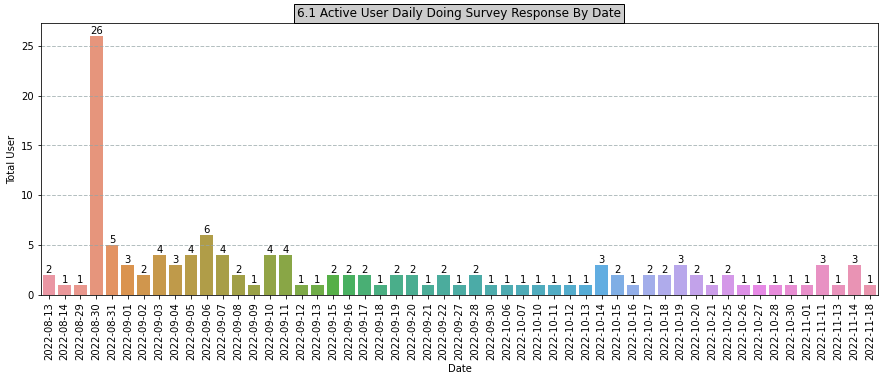

In [87]:
x = 'date'
y = 'total_user'
title = '6.1 Active User Daily Doing Survey Response By Date'
xlabel = 'Date'
ylabel = 'Total User'
x_degree = 90

show_graph(q6_1, x, y, x_degree, title, xlabel, ylabel, False, False)

In [88]:
average_survey_daily_user = q6_1['total_user'].mean()
print('Survey Response : ' + str(round(average_survey_daily_user, 2)) + ' user per day')

Survey Response : 2.43 user per day


[Back to Table of Contents](#toc)

## 6.2 Check Response Daily Active User<a class="anchor" id="section_6_2"></a>

In [89]:
q6_2 = load_query("SELECT date, COUNT(DISTINCT(user)) AS 'total_user' FROM history_check GROUP BY date;")

q6_2.head()

,date,total_user
0,2022-08-16,1
1,2022-08-18,1
2,2022-08-30,17
3,2022-08-31,5
4,2022-09-01,3


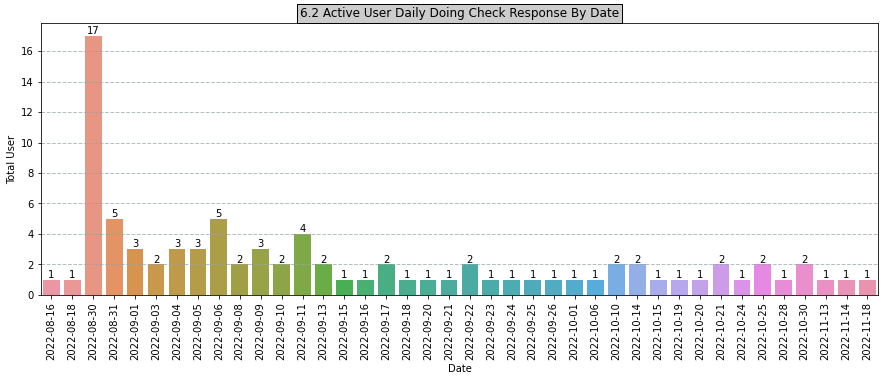

In [90]:
x = 'date'
y = 'total_user'
title = '6.2 Active User Daily Doing Check Response By Date'
xlabel = 'Date'
ylabel = 'Total User'
x_degree = 90

show_graph(q6_2, x, y, x_degree, title, xlabel, ylabel, False, False)

In [91]:
average_check_daily_user = q6_2['total_user'].mean()
print('Check Response : ' + str(round(average_check_daily_user, 2)) + ' user per day')

Check Response : 2.15 user per day


[Back to Table of Contents](#toc)

## 6.3 Total Response Daily Active User<a class="anchor" id="section_6_3"></a>

In [92]:
q6_3 = pd.DataFrame({'total_user' : history.groupby(['date'])['user'].nunique()}).reset_index()

q6_3.head()

,date,total_user
0,2022-08-13,2
1,2022-08-14,1
2,2022-08-16,1
3,2022-08-18,1
4,2022-08-29,1


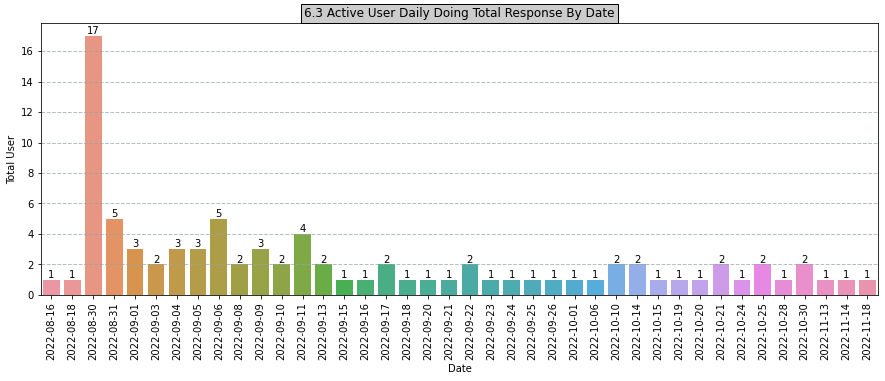

In [93]:
x = 'date'
y = 'total_user'
title = '6.3 Active User Daily Doing Total Response By Date'
xlabel = 'Date'
ylabel = 'Total User'
x_degree = 90

show_graph(q6_2, x, y, x_degree, title, xlabel, ylabel, False, False)

In [94]:
average_total_daily_user = q6_3['total_user'].mean()
print('Total Response : ' + str(round(average_total_daily_user, 2)) + ' user per day')

Total Response : 2.66 user per day


[Back to Table of Contents](#toc)

***
# 7. Daily Responses Count?<a class="anchor" id="chapter7"></a>

## 7.1 Survey Response Daily Responses Count<a class="anchor" id="section_7_1"></a>

In [95]:
q7_1 = load_query("SELECT date, SUM(responsed) AS 'total_survey_response' FROM history_survey GROUP BY date;")

q7_1.head()

,date,total_survey_response
0,2022-08-13,15
1,2022-08-14,1
2,2022-08-30,435
3,2022-08-31,90
4,2022-09-01,62


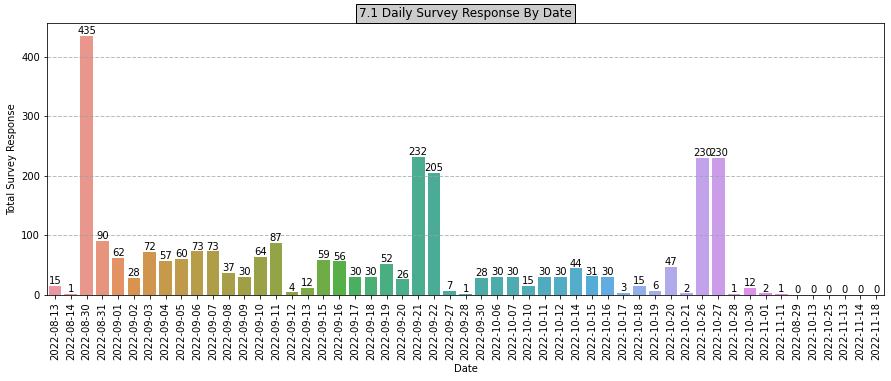

In [96]:
x = 'date'
y = 'total_survey_response'
title = '7.1 Daily Survey Response By Date'
xlabel = 'Date'
ylabel = 'Total Survey Response'
x_degree = 90

show_graph(q7_1, x, y, x_degree, title, xlabel, ylabel, False, False)

In [97]:
average_survey_responses = q7_1['total_survey_response'].mean()
print('Survey Response : ' + str(round(average_survey_responses, 2)) + ' survey responses per day')

Survey Response : 51.23 survey responses per day


[Back to Table of Contents](#toc)

## 7.2 Check Response Daily Responses Count<a class="anchor" id="section_7_2"></a>

In [98]:
q7_2 = load_query("SELECT date, SUM(checked) AS 'total_check_response' FROM history_check GROUP BY date;")

q7_2.head()

,date,total_check_response
0,2022-08-16,1
1,2022-08-18,2
2,2022-08-30,78
3,2022-08-31,187
4,2022-09-01,76


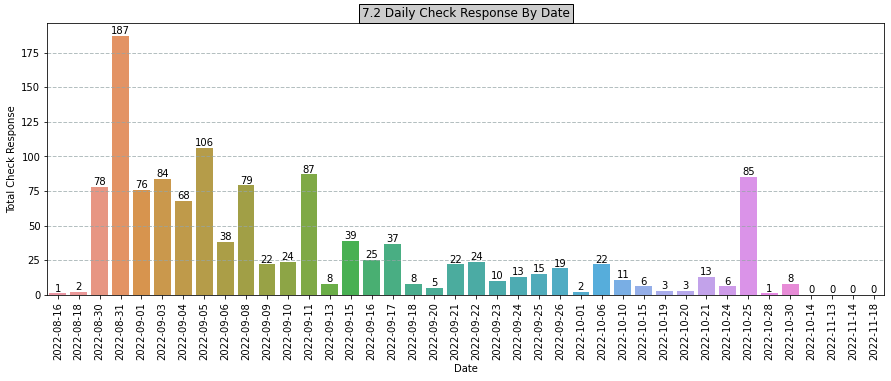

In [99]:
x = 'date'
y = 'total_check_response'
title = '7.2 Daily Check Response By Date'
xlabel = 'Date'
ylabel = 'Total Check Response'
x_degree = 90

show_graph(q7_2, x, y, x_degree, title, xlabel, ylabel, False, False)

In [100]:
average_check_responses = q7_2['total_check_response'].mean()
print('Check Response : ' + str(round(average_check_responses, 2)) + ' check data per day')

Check Response : 30.92 check data per day


[Back to Table of Contents](#toc)

## 7.3 Total Response Daily Responses Count<a class="anchor" id="section_7_3"></a>

In [101]:
q7_3 = pd.DataFrame({'total_response' : history.groupby(['date'])['response'].sum()}).reset_index()

q7_3.head()

,date,total_response
0,2022-08-13,15
1,2022-08-14,1
2,2022-08-16,1
3,2022-08-18,2
4,2022-08-29,0


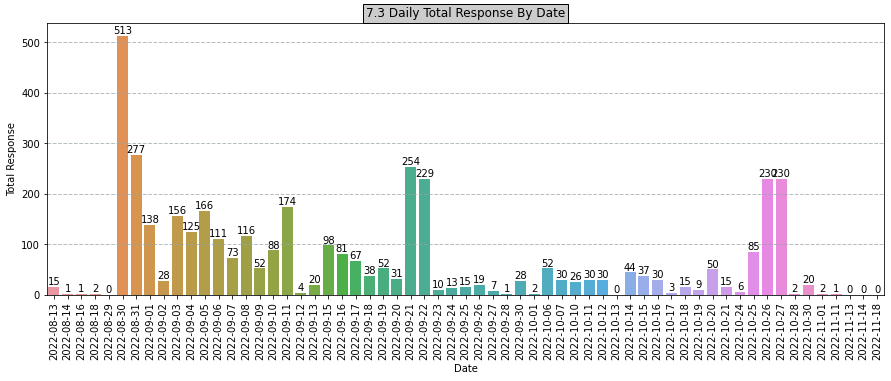

In [102]:
x = 'date'
y = 'total_response'
title = '7.3 Daily Total Response By Date'
xlabel = 'Date'
ylabel = 'Total Response'
x_degree = 90

show_graph(q7_3, x, y, x_degree, title, xlabel, ylabel, False, False)

In [103]:
average_responses = q7_3['total_response'].mean()
print('Total Response : ' + str(round(average_responses, 2)) + ' total response per day')

Total Response : 64.79 total response per day


[Back to Table of Contents](#toc)

***
# 8. Are they filling the survey out at one time or throughout the day? What times? How long is it taking?<a class="anchor" id="chapter8"></a>

How much session the have on each screen time (We assume they off screen time if they had more than 10 minutes interval between response)

## 8.1 Survey Response Session Time Long<a class="anchor" id="section_8_1"></a>

In [104]:
q8_1 = load_query("SELECT user, DATE(datetime) AS 'date' , datetime FROM response GROUP BY user, datetime ORDER BY user, datetime ;")
q8_1_final = process_session(q8_1)

q8_1_final

,index,user,date,session,min_datetime,max_datetime,session_time
0,99,214,2022-09-21,4,2022-09-21 13:04:49,2022-09-21 14:34:43,0 days 01:29:54
1,28,171,2022-09-19,1,2022-09-19 02:58:59,2022-09-19 03:32:33,0 days 00:33:34
2,58,209,2022-08-31,1,2022-08-31 02:43:05,2022-08-31 03:15:06,0 days 00:32:01
3,26,171,2022-09-15,1,2022-09-15 04:45:40,2022-09-15 05:17:30,0 days 00:31:50
4,102,214,2022-09-22,1,2022-09-22 04:45:29,2022-09-22 05:17:00,0 days 00:31:31
...,...,...,...,...,...,...,...
146,41,201,2022-08-30,1,2022-08-30 03:19:32,2022-08-30 03:19:32,0 days 00:00:00
147,42,201,2022-08-30,2,2022-08-30 03:29:46,2022-08-30 03:29:46,0 days 00:00:00
148,113,214,2022-10-19,1,2022-10-19 08:52:34,2022-10-19 08:52:34,0 days 00:00:00
149,44,202,2022-08-30,1,2022-08-30 03:18:23,2022-08-30 03:18:23,0 days 00:00:00


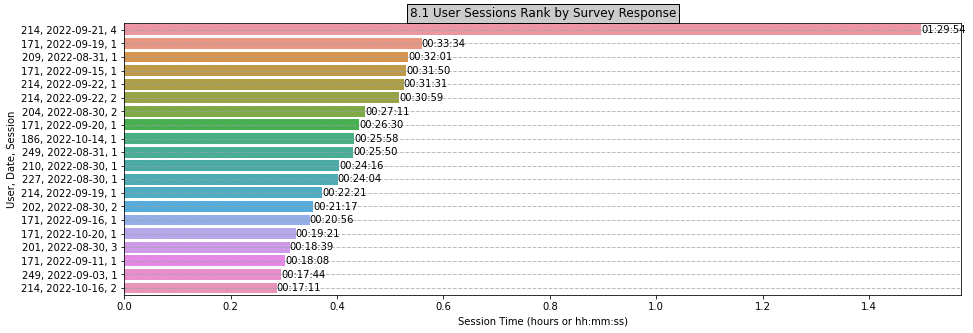

In [105]:
q8_1_final_20 = q8_1_final.head(20)

x = q8_1_final_20['session_time'] / pd.Timedelta(hours=1)
y = [str(x)+', '+str(y)+', '+str(z) for x,y,z in zip(q8_1_final_20['user'], q8_1_final_20['date'], q8_1_final_20['session'])]
title = '8.1 User Sessions Rank by Survey Response'
xlabel = 'Session Time (hours or hh:mm:ss)'
ylabel = 'User, Date, Session'
custom_label = q8_1_final_20['session_time'].astype(str).map(lambda x: x[7:])

show_graph(q8_1_final_20, x, y, 0, title, xlabel, ylabel, custom_label, False)

In [106]:
average_survey_session = q8_1_final['session_time'].mean()
print('Average survey session : ' + timedelta_format(average_survey_session) + ' session time')

Average survey session : 0:07:53 session time


[Back to Table of Contents](#toc)

## 8.2 Check Response Session Time Long<a class="anchor" id="section_8_2"></a>

In [107]:
q8_2 = load_query("SELECT user, DATE(datetime) AS 'date' , datetime FROM check_response GROUP BY user, datetime ORDER BY user, datetime ;")
q8_2_final = process_session(q8_2)

q8_2_final.head()

,index,user,date,session,min_datetime,max_datetime,session_time
0,24,171,2022-10-25,1,2022-10-25 23:10:51,2022-10-25 23:42:56,0 days 00:32:05
1,82,249,2022-08-31,2,2022-08-31 03:08:58,2022-08-31 03:38:35,0 days 00:29:37
2,90,249,2022-09-05,4,2022-09-05 02:46:35,2022-09-05 03:07:54,0 days 00:21:19
3,20,171,2022-09-11,1,2022-09-11 07:54:25,2022-09-11 08:08:00,0 days 00:13:35
4,92,249,2022-09-08,1,2022-09-08 02:51:29,2022-09-08 03:05:03,0 days 00:13:34


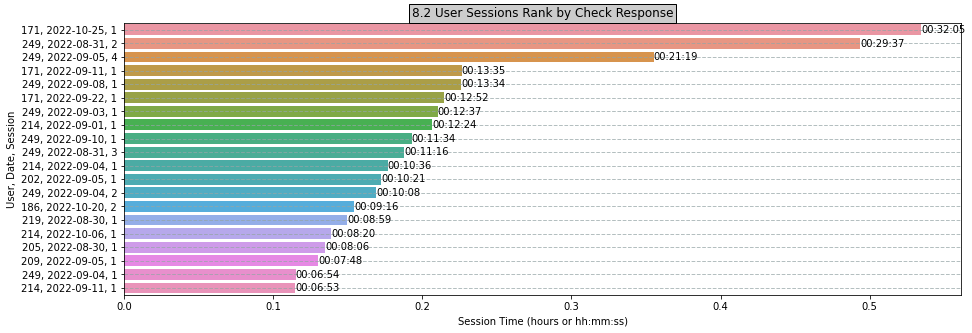

In [108]:
q8_2_final_20 = q8_2_final.head(20)

x = q8_2_final_20['session_time'] / pd.Timedelta(hours=1)
y = [str(x)+', '+str(y)+', '+str(z) for x,y,z in zip(q8_2_final_20['user'], q8_2_final_20['date'], q8_2_final_20['session'])]
title = '8.2 User Sessions Rank by Check Response'
xlabel = 'Session Time (hours or hh:mm:ss)'
ylabel = 'User, Date, Session'
custom_label = q8_2_final_20['session_time'].astype(str).map(lambda x: x[7:])

show_graph(q8_2_final_20, x, y, 0, title, xlabel, ylabel, custom_label, False)

In [109]:
average_check_session = q8_2_final['session_time'].mean()
print('Average check session : ' + timedelta_format(average_check_session) + ' session time')

Average check session : 0:04:32 session time


[Back to Table of Contents](#toc)

## 8.3 Total Response Session Time Long<a class="anchor" id="section_8_3"></a>

In [110]:
q8_3 = response_combine[['user', 'datetime']].copy()
q8_3['date'] = q8_3['datetime'].dt.date
q8_3 = q8_3.sort_values(by=['user', 'datetime']).reset_index()
q8_3_final = process_session(q8_3)

q8_3_final.head()

,index,user,date,session,min_datetime,max_datetime,session_time
0,133,214,2022-09-21,4,2022-09-21 13:04:49,2022-09-21 14:34:43,0 days 01:29:54
1,183,249,2022-08-31,2,2022-08-31 03:08:58,2022-08-31 04:05:48,0 days 00:56:50
2,39,171,2022-09-11,1,2022-09-11 07:26:30,2022-09-11 08:08:00,0 days 00:41:30
3,68,204,2022-08-30,2,2022-08-30 03:19:03,2022-08-30 03:53:09,0 days 00:34:06
4,43,171,2022-09-19,1,2022-09-19 02:58:59,2022-09-19 03:32:33,0 days 00:33:34


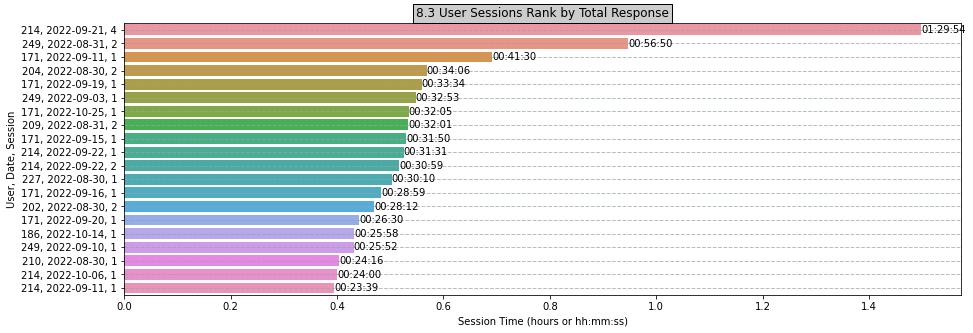

In [111]:
q8_3_final_20 = q8_3_final.head(20)

x = q8_3_final_20['session_time'] / pd.Timedelta(hours=1)
y = [str(x)+', '+str(y)+', '+str(z) for x,y,z in zip(q8_3_final_20['user'], q8_3_final_20['date'], q8_3_final_20['session'])]
title = '8.3 User Sessions Rank by Total Response'
xlabel = 'Session Time (hours or hh:mm:ss)'
ylabel = 'User, Date, Session'
custom_label = q8_3_final_20['session_time'].astype(str).map(lambda x: x[7:])

show_graph(q8_3_final_20, x, y, 0, title, xlabel, ylabel, custom_label, False)

In [112]:
average_total_session = q8_3_final['session_time'].mean()
print('Average total session : ' + timedelta_format(average_total_session) + ' session time')

Average total session : 0:08:15 session time


[Back to Table of Contents](#toc)

***
# 9. List of have not been confirmed Responses after check data<a class="anchor" id="chapter9"></a>

In [113]:
q9 = response_df[response_df['check_status'] == 2].copy()
q9 = q9[['data_type', 'prompt', 'response_id', 'response']]
q9_word = q9[q9['data_type'] == 1]
q9_word_merge = pd.merge(prompt_word_df, q9_word, how='inner', left_on=['prompt_id'], right_on=['prompt'])
q9_word_merge[['prompt_id', 'prompt', 'hint', 'response_id', 'response']] = q9_word_merge[['prompt_id', 'prompt_x', 'hint', 'response_id', 'response']]
q9_word_merge_final = q9_word_merge[['prompt_id', 'prompt', 'hint', 'response_id', 'response']]

q9_sentence = q9[q9['data_type'] != 1]
q9_sentence_merge = pd.merge(prompt_sentence_df, q9_sentence, how='inner', left_on=['prompt_id'], right_on=['prompt'])
q9_sentence_merge[['prompt_id', 'prompt', 'response_id', 'response']] = q9_sentence_merge[['prompt_id', 'prompt_x', 'response_id', 'response']]
q9_sentence_merge_final = q9_sentence_merge[['prompt_id', 'prompt', 'response_id', 'response']]

manual_check_data_list = pd.concat([q9_word_merge_final, q9_sentence_merge_final], ignore_index = True, sort = False)

manual_check_data_list.head()

,prompt_id,prompt,hint,response_id,response
0,339,Kata yang digunakan untuk menyebut sisa endap...,endapan,2979,muke
1,1505,Kata yang digunakan untuk menyebut lebih dari...,penduduk,1441,khombongon kalak kute
2,1505,Kata yang digunakan untuk menyebut lebih dari...,penduduk,1586,kute
3,1505,Kata yang digunakan untuk menyebut lebih dari...,penduduk,1590,penduduk
4,1506,Kata yang digunakan untuk menyebut seluruh um...,orang,1268,apa


In [114]:
# Convert dataframe to CSV
print_csv(manual_check_data_list, 'manual_check_data_list')

Data manual_check_data_list Printed to CSV


[Back to Table of Contents](#toc)

***
# 10. List of confirmed Response<a class="anchor" id="chapter10"></a>

In [115]:
confirmed_response = response_df[response_df['check_status'] == 1].copy()
confirmed_response = confirmed_response[['response_id', 'response', 'user', 'data_type', 'prompt']]

confirmed_prompt = prompt_combine[['prompt_id', 'data_type', 'prompt']].copy()
confirmed_prompt_response = pd.merge(confirmed_prompt, confirmed_response, how='inner', left_on=['prompt_id', 'data_type'], right_on=['prompt', 'data_type'])

confirmed_prompt_response['prompt'] = confirmed_prompt_response['prompt_x']
confirmed_prompt_response = confirmed_prompt_response[['prompt_id', 'prompt', 'response_id', 'user', 'response', 'data_type']]

confirmed_check_response = check_response_df[['check_responseid', 'check_response', 'user', 'response', 'check_type', 'check_status']].copy()
confirmed_check_response = confirmed_check_response[confirmed_check_response['check_status'] == 1]
confirmed_prompt_check_response = pd.merge(confirmed_prompt_response, confirmed_check_response, how='inner', left_on=['response_id'], right_on=['response'])

confirmed_prompt_check_response[['user','response', 'check_user']] = confirmed_prompt_check_response[['user_x','response_x', 'user_y']]
confirmed_prompt_check_response = confirmed_prompt_check_response[['prompt_id', 'prompt', 'response_id', 'user', 'response', 'data_type', 'check_responseid', 'check_user', 'check_response', 'check_type']]

confirmed_prompt_check_response = pd.merge(confirmed_prompt_check_response, check_type_df, how='inner', left_on=['check_type'], right_on=['check_typeid'])

confirmed_prompt_check_response['check_type'] = confirmed_prompt_check_response['check_type_y']
list_confirmed = confirmed_prompt_check_response[['prompt_id', 'prompt', 'response_id', 'user', 'response', 'data_type', 'check_responseid', 'check_user', 'check_response', 'check_type']]

list_confirmed.head()

,prompt_id,prompt,response_id,user,response,data_type,check_responseid,check_user,check_response,check_type
0,1,segala sesuatu yang dapat kita lihat,2949,209,alam semesta,1,3046,249,alam semesta,DAILY CHECK
1,9,Kata yang digunakan untuk menyebut tempat atau...,2988,214,sugekh,1,3066,249,segar,DAILY CHECK
2,10,Kata yang digunakan untuk menyebut tempat atau...,2997,214,luakh angkase,1,3030,249,luar angkasa,DAILY CHECK
3,11,Kata yang menjelaskan sifat sesuatu yang ada d...,2946,209,ni langit,1,3034,249,di langit,DAILY CHECK
4,12,Kata yang menjelaskan sifat sesuatu yang ada d...,2995,214,di ndatas langit,1,3050,249,di atas langit,DAILY CHECK


In [116]:
sentence_list_confirmed = list_confirmed[list_confirmed['data_type'] != 1]
word_list_confirmed = list_confirmed[list_confirmed['data_type'] == 1]

# Convert dataframe to CSV
print_csv(sentence_list_confirmed, 'sentence_list_confirmed')

print_csv(word_list_confirmed, 'word_list_confirmed')

Data sentence_list_confirmed Printed to CSV
Data word_list_confirmed Printed to CSV


[Back to Table of Contents](#toc)